# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# formula api vs. array-based
import statsmodels.formula.api as smf

# panel OLS for sanity check
from linearmodels.panel import PanelOLS

# contrasts for sanity check
from patsy.contrasts import Treatment

import warnings

# Project Summary

In this project, I investigate whether liberalizing divorce law causally affects a country’s income inequality, measured by the Gini index. This is a broad causal question that requires explicit assumptions.

The data are observational. Countries adopt reforms at different calendar years, so there is no single “treatment time.” Two natural designs for this type of data are:

1. Country-by-country 2×2 DiD (each country as its own two-period, two-group comparison)
2. Staggered adoption designs (multiple units and periods with different adoption years)

The per-country 2×2 design is not feasible here, as treatment status and outcomes are national aggregates, which means that a country cannot serve as its own control. Propensity-matched external controls or synthetic controls could be used, but my goal is to identify global (and regional) patterns rather than within-country effects. I therefore focus on staggered DiD.

I follow the design guidance in Baker, Callaway, Cunningham, Goodman-Bacon, and Sant’Anna (2025), Difference-in-Differences Designs: A Practitioner’s Guide (arXiv:2503.13323). https://arxiv.org/pdf/2503.13323

I implement two staggered strategies:

**I. Cohort Approach**

I group countries into per-decade cohorts, according to the decade in which divorce law reform occurred. Each cohort’s “event time” is anchored at the cohort’s modal adoption year, and I estimate a TWFE regression within each cohort.

Unfortunately, binning countries into cohorts leads to data contamination, both in controls and treated groups. 

Controls may include already-treated countries (if a country’s true reform was before the cohort modal year), and treated-post may include not-yet-treated countries (if a country’s true reform was after the cohort mode). Given that legal and social changes evolve gradually, limited within-decade contamination may be acceptable, but is less than ideal.

**II. Event-Study Approach**

Rather than focus on calendar years, I evaluate pre and post groups in terms of relative time-distance from the treatment year. This avoids contamination because no treated-post-treatment country is ever included in controls, and no untreated country is ever included in treated-post-treatment. 

While avoiding contamination, the event study approach over long time periods strains credulity. In other words, taking an event study approach requires that I superimpose 1975 onto 1995, as if there were no salient differences between those two time periods. H

owever, if countries tend to change drastically, some time after treatment, this would surely be identified in an event study. One nuanced approach might be to conduct an event study for each decade cohort, which may be the next step I take in this project.

A practical compromise is to run event studies within decade cohorts, which I plan as a next step.

**Inference**

I use frequentist inference (t-tests from statsmodels) and plan to explore Bayes-factor sensitivity as future work.

**Treatment Coding**

Divorce regimes vary in restrictiveness:

1. Illegal
2. Fault-based only (no “irreconcilable differences”)
3. No-fault (lite/mutual): breakdown recognized but may require proof, separation periods, or mutual consent
4. No-fault (unilateral): one party’s assertion suffices

For analysis, I collapse the above four categories into two groups:

Group I ("never treated"): No recognition of “irretrievable breakdown/irreconcilable differences,” or procedures that are substantively one-sided/unfair

Group II (treated or not-yet-treated): No-fault permitted (including recognition of irretrievable breakdown/irreconcilable differences)

**Core Assumptions**

I consider standard parallel-trends formulations:

**PT–GT–All**: Parallel trends across all groups and periods (used in the baseline for this study)
- I chose to assume PT-GT-All, given my global aspirations

**PT–GT–Never**: Parallel trends relative to never-treated groups
- Never-treated countries are in fact very different from countries that are treated, in ways that would affect outcomes. Thus, this PT assumption is not viable for my data.

**PT–GT–NYT**: Parallel trends relative to not-yet-treated groups
- Similar to the PT-GT-Never, countries that are treated at all are in fact very different from countries that are never treated, thus adopting the NYT would introduce the opposite type of bias.

# Background: Data and Dependencies

This study complements my parallel project, CoResidence Analysis (repo: https://github.com/LittleBiggler/CoResidence)

Exploratory visuals from that work show several features with inflection points in the 1970s–1980s and broad shifts toward households that are (1) older and (2) more often female-headed. During this period, the share of female-headed households rose, average number of children per household fell, and household age increased. If household configuration relates to inequality, *something important* appears to change in the 1970s–1980s.

When I consider shocks that plausibly reshape household structure—illness, job loss, and divorce—divorce stands out as both substantively meaningful, and empirically tractable: adoption years are relatively easy to document across countries. Beyond data availability, a society’s willingness to liberalize divorce is signal-rich, reflecting deep shifts in norms and interpersonal arrangements.

Because I analyze countries globally, my hope is that cross-country heterogeneity helps “average out” idiosyncratic parallel trends, sharpening identification on divorce law as a potential causal catalyst rather than on unrelated confounders.

**Gini Handling** 

Where annual values were missing, I imputed the Gini series. Prior to imputation, I inverted its scale for interpretability (higher = more equality), consistent with the approach in CoResidence. See that project’s “Target Imputation” section for details. (Substantive conclusions are always conditional on the imputation strategy.)

**Divorce Data**

I compiled no-fault divorce adoption years primarily via targeted Google searches, following links to government sources or (frequently) law-firm explainers aimed at prospective clients. I did not rely on AI overviews. For a fully rigorous legal history, collaboration with legal scholars would be appropriate; for this exploratory study, curated web sources were sufficient. I cross-referenced my findings with an amateur compilation from World Population Review (cited below).

Citations

Baker, Callaway, Cunningham, Goodman-Bacon, and Sant’Anna (2025), Difference-in-Differences Designs: A Practitioner’s Guide (arXiv:2503.13323). https://arxiv.org/pdf/2503.13323

Countries Where Divorce Is Illegal 2025. World Population Review. Retrieved June 19, 2025, from https://worldpopulationreview.com/country-rankings/countries-where-divorce-is-illegal




# CoResidence Data

CoResidence with all merges and imputed targets


In [2]:
# read in data

df_raw = pd.read_csv('./artifact/cores_full_merge.csv')
df_raw.shape

(7808, 159)

In [3]:
df = df_raw.copy()

In [4]:
# take oly the columns neede for gini analysis
# potential to include covariates later

df = df_raw[['Country Name', 'Country Code', 'Year', 'Gini_recon_hybrid', 'Gini','Gini_missing']]

In [5]:
df.shape

(7808, 6)

# Divorce Data

In [6]:
# import original divorce data, compiled by me
divorce_data = pd.read_csv('./divorce_table_final.csv', index_col=0)
divorce_data.head()

,Country,Blame Based,Fault Comment,Irreconcilable Differences,No Fault Comment,Treatment Y/N,Treatment Year,Unnamed: 8,Fault Based,Mutual No Fault,Unilateral No Fault
0,Afghanistan,1977.0,Fault required,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
1,Albania,2003.0,Fault required,2013.0,Favors men,No,NaN,NaN,NaN,NaN,NaN
2,Algeria,1984.0,Fault required,2005.0,Favors men,No,NaN,NaN,NaN,NaN,NaN
3,Angola,NaN,NaN,1975.0,No fault,Yes,1976.0,NaN,Yes,Yes,One year separation
4,Argentina,1987.0,Fault required,2015.0,No fault,Yes,2016.0,NaN,No,Yes,Yes


In [7]:
# convert "Treatment Y/N" to integer

divorce_data['Treatment'] = divorce_data['Treatment Y/N'].map({'Yes':1, 'No':0})

In [8]:
# check if any years are missing from treatment

mask = (divorce_data['Treatment'].eq(1) & divorce_data['Treatment Year'].isnull())
    
if mask.any():  
    print(f"Uh-oh, year missing for {divorce_data.loc[mask, 'Country'].to_list()}")
else:
    print('All good and tidy.')

All good and tidy.


In [9]:
# check if any untreated years have a date in the "Treatment Year" column by accident

mask = (divorce_data['Treatment Y/N']=='No') & (divorce_data['Treatment Year'].notnull())

if mask.any():
    print(f"Uh-oh, year missing for {divorce_data.loc[mask, 'Country'].to_list()}")
else:
    print('All good and tidy.')

All good and tidy.


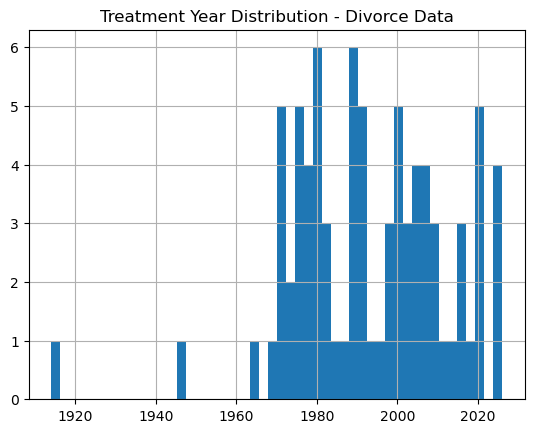

In [10]:
# visualize divorce year

divorce_data['Treatment Year'].hist(bins=50)
plt.title('Treatment Year Distribution - Divorce Data')
plt.show()

# Merge: CoResidence & Divorce Data

In [11]:
# anticipate merge failures

[country for country in df['Country Name'].unique() if country not in divorce_data['Country'].unique()]

['Congo, Dem. Rep.',
 'Czechia',
 'Egypt, Arab Rep.',
 'Gambia, The',
 'Iran, Islamic Rep.',
 'Korea, Rep.',
 'Lao PDR',
 'North Macedonia',
 'West Bank and Gaza',
 'Russian Federation',
 'Slovak Republic',
 'Venezuela, RB',
 'Viet Nam',
 'Yemen, Rep.']

In [12]:
# name mapper for improved merge:

country_name_mapper = {
    'Congo, Dem. Rep.':'Congo',
 'Czechia':'Czech Republic',
 'Egypt, Arab Rep.':'Egypt',
 'Gambia, The':'Gambia',
 'Iran, Islamic Rep.':'Iran',
 'Korea, Rep.':'South Korea',
 'Lao PDR':'Laos',
 'North Macedonia':'Macedonia',
 'West Bank and Gaza':'Palestine',
 'Russian Federation':'Russia',
 'Slovak Republic':'Slovakia',
 'Venezuela, RB':'Venezuela',
 'Viet Nam':'Vietnam',
 'Yemen, Rep.':'Yemen'
}

# reverse
country_name_mapper = {
    value:key for key, value in country_name_mapper.items()
}


In [13]:
# update names in right table to prepare for successful merge

divorce_data['Country'] = divorce_data['Country'].replace(country_name_mapper)


In [14]:
# left merge with divorce data

df_mstr = df.merge(divorce_data, left_on='Country Name', right_on='Country', how='left')

In [15]:
# drop columns not needed 
columns_to_drop = ['Unnamed: 8', 'Fault Based', 'Mutual No Fault', 'Unilateral No Fault']
df_mstr = df_mstr.drop(columns=columns_to_drop)

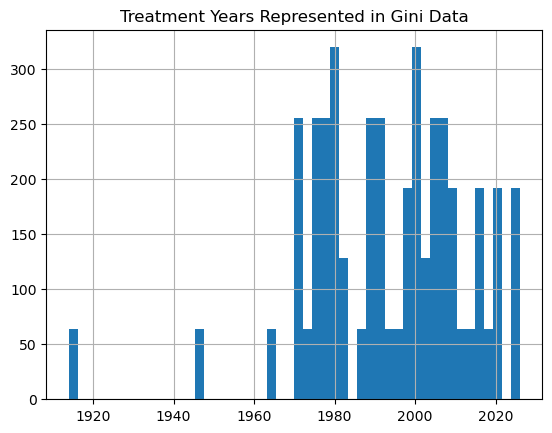

Percentage of observations ever treated: 54.92%


In [16]:
# Plot treatment years represented in merged data

df_mstr['Treatment Year'].hist(bins=50)
plt.title('Treatment Years Represented in Gini Data')
plt.show()

# size of treated vs. not treated, by year
percent_treated = df_mstr['Treatment Year'].notnull().sum()/len(df_mstr)
print(f"Percentage of observations ever treated: {percent_treated*100:.2f}%")

# Data Prep

Prepare the data for DiD-specific requirements, including removing singletons and ensuring that each cohort has at least 30 instances of treated data

In [17]:
print(df_mstr['Country'].nunique())
df_mstr.shape

122


(7808, 14)

In [18]:
# OnTreat column tracks which entities and years have received treatment

df_mstr['OnTreat'] = (
    (df_mstr['Year']>=df_mstr['Treatment Year']) & df_mstr['Treatment'].eq(1)
).astype(int)


In [19]:
# create treatment cohorts

def treatment_cohort(treatment_year):
    """Takes treatment year and assigns to a cohort"""
    if pd.isna(treatment_year):
        return np.nan
    floor_decade = int((treatment_year)//10*10)
    ceiling_decade = floor_decade + 9
    treatment_cohort = f"{floor_decade}-{ceiling_decade}"
    return(treatment_cohort)
    

In [20]:
# create treatment cohorts using formula

df_mstr['Treatment Cohort'] = df_mstr['Treatment Year'].apply(lambda x: treatment_cohort(x))

print(f"Treatment Cohorts: {sorted(df_mstr['Treatment Cohort'].dropna().unique())}")

Treatment Cohorts: ['1910-1919', '1940-1949', '1960-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2019', '2020-2029']


In [21]:
# define viable group as having both pre and post years (when treated)

def group_viability(group):
    """Tests a group for DiD viability"""
    min_t = group['OnTreat'].min()
    max_t = group['OnTreat'].max()

    viable_group_mask = ((min_t==0) & (max_t==1)) | (max_t==0)
    viable_group_mask &= (group['Year'].nunique()>=2)

    viable_groups = viable_group_mask[viable_group_mask].index
    
    return viable_groups

In [22]:
# 
group = df_mstr.groupby('Country')

viable_countries = group_viability(group)
viable_countries

Index(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria',
       'Bangladesh', 'Belarus', 'Belgium', 'Benin',
       ...
       'Ukraine', 'United Kingdom', 'United States', 'Uzbekistan',
       'Venezuela, RB', 'Viet Nam', 'West Bank and Gaza', 'Yemen, Rep.',
       'Zambia', 'Zimbabwe'],
      dtype='object', name='Country', length=120)

In [23]:
# filter df_mstr down to appropriate countries only
# "singleton" countries are filtered out
# further filtering will be needed by cohort or event time group

#df_mstr = df_mstr[df_mstr['Country'].isin(viable_countries)]
df_mstr.shape

(7808, 16)

### df_mstr change log

df_mstr has gone through preliminary preparatory steps to ensure best outcomes in the varying DiD approaches that follow. Further filtering may be needed to ensure that event time requirements are met.

For now, the following changes were made to **df_mstr** vs. raw data, after the left merge with divorce data:

1) OnTreat column created
2) Singleton treated countries filtered out
3) Treatment cohort column created

Singleton countries are countries lacking in either intra-unit or time variation. In other words, treated countries that lack a pre-treatment year, or never-treated countries with less than two years of data. Without variation, no difference in difference can be calculated. These countries have been filtered out using a function written for the purpose: **group_viability()**


## Cohort Study with smf.OLS()

In [26]:
# create a copy of the master data 

df_did = df_mstr.copy()

In [29]:
# countries per cohort

df_did.groupby('Treatment Cohort').agg(count = ('Country', 'nunique'))

,count
Treatment Cohort,
1910-1919,1
1940-1949,1
1960-1969,1
1970-1979,14
1980-1989,9
1990-1999,11
2000-2009,17
2010-2019,7
2020-2029,6


In [30]:
# define viable cohort to avoid 

group = df_did.groupby('Treatment Cohort')

viable_cohorts = group_viability(group)
viable_cohorts

Index(['1960-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009',
       '2010-2019', '2020-2029'],
      dtype='object', name='Treatment Cohort')

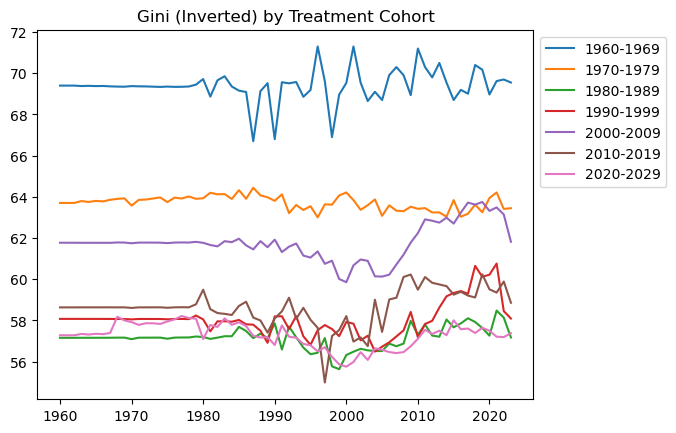

In [31]:
# visualize cohort trends

fig, ax = plt.subplots()

for cohort in viable_cohorts:
    
    annual_agg = (
        df_mstr[df_mstr['Treatment Cohort']==cohort]
        .groupby('Year', as_index=False).agg(Annual_Gini=('Gini_recon_hybrid', 'mean'))
    )
    x_axis = annual_agg['Year']
    y_axis = annual_agg['Annual_Gini']

    plt.plot(x_axis, y_axis, label = cohort)
    plt.legend(bbox_to_anchor=(1,1))

plt.title("Gini (Inverted) by Treatment Cohort")
plt.show()

In [32]:
# DiD

# initiate dictionaries to store results
results = {}
warn_log = {}
custom_summary = []

Y = 'Gini_recon_hybrid'
target = 'Treatment:OnTreat'

for cohort in viable_cohorts:
    print(cohort)
    treated_mask = df_did['Treatment Cohort']==cohort #all cohorts by definition are treated
    treated = df_did[treated_mask]

    benchmark_year = treated['Treatment Year'].mode().iat[0] #treatment year per cohort
    
    # control groups:
    # never treated & not-yet-treated (where years come before treatment)
    never_treated_mask = df_did['Treatment']== 0
    not_yet_treated_mask = (df_did['Treatment Year'].gt(benchmark_year) 
                            & df_did['Year'].lt(df_did['Treatment Year']))
    control_mask = never_treated_mask | not_yet_treated_mask
                            
    subset = df_did.loc[treated_mask | control_mask].copy()
    
    # identify countries with fewer than 2 observations
    singleton_countries = subset['Country'].value_counts().loc[lambda x: x<2]
    print(cohort, singleton_countries)
    
    # drop singleton countries
    subset = subset[~subset['Country'].isin(singleton_countries)].copy()
    
    # DiD formula
    formula = f"{Y} ~ Treatment:OnTreat + C(Year) + C(Country)"
    
    

    result = smf.ols(formula=formula, data=subset).fit(
    cov_type = 'cluster',
    cov_kwds = {'groups': subset['Country']})
        

    
    # collect results in dictionary
    results[cohort] = result

    # generate DiD stats
    coef = result.params.get(target, np.nan)
    se = result.bse.get(target, np.nan)
    tval = result.tvalues.get(target, np.nan)
    pval = result.pvalues.get(target, np.nan)
    
    if (not np.isfinite(se)) or (se==0):
        warn_log.setdefault(cohort, []).append(
            f"SE invalid (se={se}); clusters={subset['Country'].nunique()}"
        )
        
    # gather DiD stats
    custom_summary.append({
        "cohort" : cohort,
        "coef": coef,
        "se":se,
        "tval": tval,
        "pval": pval
    }
    )

1960-1969
1960-1969 Series([], Name: Country, dtype: int64)
1970-1979
1970-1979 Series([], Name: Country, dtype: int64)


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


1980-1989
1980-1989 Series([], Name: Country, dtype: int64)
1990-1999
1990-1999 Series([], Name: Country, dtype: int64)
2000-2009
2000-2009 Series([], Name: Country, dtype: int64)
2010-2019
2010-2019 Series([], Name: Country, dtype: int64)
2020-2029
2020-2029 Series([], Name: Country, dtype: int64)


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [33]:
# inspect custom summary
custom_summary = pd.DataFrame(custom_summary)
custom_summary

,cohort,coef,se,tval,pval
0,1960-1969,0.056761,0.031125,1.823670,0.068202
1,1970-1979,0.000165,0.172848,0.000957,0.999236
2,1980-1989,0.140867,0.065704,2.143982,0.032034
3,1990-1999,0.296859,0.165143,1.797586,0.072243
4,2000-2009,0.571908,0.299590,1.908971,0.056266
5,2010-2019,0.601090,0.862211,0.697150,0.485709
6,2020-2029,-0.573471,0.173415,-3.306929,0.000943


In [34]:
# inspect warnings for DiD term
warn_log

{}

## Cohort with PanelOLS

In [35]:
# create a copy
df_panel = df_did.copy()


In [36]:
# set index as required by panel ols
df_panel = df_panel.set_index(['Country', 'Year'])

In [45]:
# try with panel ols

panel_results = {}
panel_summary = []

for cohort in viable_cohorts:
    print(cohort)
    
    benchmark_year = df_panel.loc[df_panel['Treatment Cohort']==cohort, 'Treatment Year'].mode().iat[0]
    print(benchmark_year)
    
    treated_mask = df_panel['Treatment Cohort'] == cohort
    
    never_treated_mask = df_panel['Treatment'] == 0
    not_yet_treated_mask = (
        (df_panel['Treatment Year'] > benchmark_year) & 
        (df_panel.index.get_level_values('Year') < df_panel['Treatment Year'])
    )
    
    control_mask = never_treated_mask | not_yet_treated_mask
    
    es_cols = ['OnTreat']
    
    subset = df_panel.loc[treated_mask | control_mask, es_cols]
    
    y = df_panel.loc[subset.index, 'Gini_recon_hybrid']
    X = subset.copy()
    
    model = PanelOLS(y, X, entity_effects=True, time_effects=True)
    result = model.fit(cov_type='clustered', cluster_entity=True, cluster_time=False)
    
    panel_results[cohort] = result
    
    # build custom summary
    panel_summary.append(
        {
        'cohort_':cohort,
        'coefficient': result.params.iat[0],
        'standard error': result.std_errors.iat[0],
        'p_value': result.pvalues.iat[0],
        't_value': result.tstats.iat[0]
    }
    )
    

1960-1969
1965.0
1970-1979
1977.0
1980-1989
1980.0
1990-1999
1992.0
2000-2009
2001.0
2010-2019
2016.0
2020-2029
2021.0


In [46]:
panel_summary = pd.DataFrame(panel_summary)

panel_summary

,cohort_,coefficient,standard error,p_value,t_value
0,1960-1969,0.056761,0.030998,0.067129,1.831161
1,1970-1979,0.000165,0.172133,0.999233,0.000961
2,1980-1989,0.140867,0.065395,0.031275,2.154085
3,1990-1999,0.296859,0.164295,0.070837,1.806864
4,2000-2009,0.571908,0.297850,0.054897,1.920121
5,2010-2019,0.601090,0.855946,0.482561,0.702252
6,2020-2029,-0.573471,0.172010,0.000864,-3.333946


In [47]:
side_by_side = pd.DataFrame(pd.concat([custom_summary, panel_summary], axis=1))
side_by_side

,cohort,coef,se,tval,pval,cohort_,coefficient,standard error,p_value,t_value
0,1960-1969,0.056761,0.031125,1.823670,0.068202,1960-1969,0.056761,0.030998,0.067129,1.831161
1,1970-1979,0.000165,0.172848,0.000957,0.999236,1970-1979,0.000165,0.172133,0.999233,0.000961
2,1980-1989,0.140867,0.065704,2.143982,0.032034,1980-1989,0.140867,0.065395,0.031275,2.154085
3,1990-1999,0.296859,0.165143,1.797586,0.072243,1990-1999,0.296859,0.164295,0.070837,1.806864
4,2000-2009,0.571908,0.299590,1.908971,0.056266,2000-2009,0.571908,0.297850,0.054897,1.920121
5,2010-2019,0.601090,0.862211,0.697150,0.485709,2010-2019,0.601090,0.855946,0.482561,0.702252
6,2020-2029,-0.573471,0.173415,-3.306929,0.000943,2020-2029,-0.573471,0.172010,0.000864,-3.333946


In [48]:
# extract significant cohorts

alpha = .05
significant_cohorts = side_by_side[side_by_side['pval']<=alpha]
print(significant_cohorts[['cohort', 'coefficient', 'standard error', 'p_value', 't_value']].to_markdown(index=False))



| cohort    |   coefficient |   standard error |     p_value |   t_value |
|:----------|--------------:|-----------------:|------------:|----------:|
| 1980-1989 |      0.140867 |        0.0653954 | 0.0312745   |   2.15408 |
| 2020-2029 |     -0.573471 |        0.17201   | 0.000864482 |  -3.33395 |


## Summary

Staggered DiD regressions per cohort revealed statistically significant effects for two cohorts:

| cohort    |   coefficient |   standard error |     p_value |   t_value |
|:----------|--------------:|-----------------:|------------:|----------:|
| 1980-1989 |      0.140867 |        0.0653954 | 0.0312745   |   2.15408 |
| 2020-2029 |     -0.573471 |        0.17201   | 0.000864482 |  -3.33395 |

Gini values have been previously inverted to improve interpretability. Normally, high Gini values indicate high levels of inequality. Thus, a positive coefficient corresponds to a decrease in Gini values, and a decrease in wealth inequality.

Unfortunately, staggered cohorts require assigning a 'Treatment Year' per cohort, which is the mode of the treatment years in that cohort. By definition, benchmarking to the mode year will capture most of the treatment years in the cohort. However, this will also contaminate data, which does not have the mode treatment year.

Binning cohorts in the case of my dataset was a preliminary step. 

# Event Study - Manual ATT

I calculate the average treatment effect on the treated (ATT) manually and directly, with boostrapped CI's, for full visibility. (This project is a learning opportunity for me, and I treat the manual ATT calculation as a deep dive to develop solid intuition.)

In [81]:
# copy mstr df and create relative year column

df_es = df_mstr.copy()



In [82]:
# create a "relative year" column for observations and bin the tails

df_es['rel_year'] = (df_es['Year'] - df_es['Treatment Year'])


In [83]:
# assess viability per e

group = df_es.groupby('rel_year')

viable_relyears = group_viability(group)

# all pre-years viable

In [91]:
# plot ATT per e

cell_dict = []
countries = viable_countries

for country in countries:
    # treatment year in calendar time
    Gi = df_es.loc[df_es['Country']==country, 'Treatment Year'].iat[0]
    
    # tzero is e = -1 (baseline year)
    t_0 = Gi - 1
    
    # treated units at tzero (baseline)
    treated_t0_mask = ((df_es['Treatment']==1) & (df_es['Country']==country) & (df_es['Year']==t_0))
    
    s_t0 = df_es.loc[treated_t0_mask, 'Gini_recon_hybrid']
    treated_t0 = s_t0.iat[0] if s_t0.notna().any() else np.nan
    print(country, treated_t0)
    
    # control units at tzero (baseline)
    control_t0_mask = (
            (df_es['Year']==t_0) &
            ((df_es['Treatment']==0) | ((df_es['Treatment']==1) & (df_es['Treatment Year'] > t_0))) & #NT & NYT
            (df_es['Country']!= country) & #control for country FE
            (df_es['Treatment Year']!= Gi) #control for year FE
        )

    s_t0 = df_es.loc[control_t0_mask, 'Gini_recon_hybrid']
    control_t0 = s_t0.mean() if s_t0.notna().any() else np.nan #avg all control units for tzero
        

    # event time list for country in question
    e_list = list(df_es.loc[df_es['Country']==country, 'rel_year'].dropna())

    
    for e in e_list:
        # event time (calendar year for each e)
        t_i = df_es.loc[((df_es['Country']==country) & (df_es['rel_year']==e)), 'Year'].iat[0]

        
        # treated gini value at calendar year corresponding to e
        treated_ti_mask = ((df_es['Treatment']==1) & (df_es['Country']==country) & (df_es['Year']==t_i))
        
        treated_ti = df_es.loc[treated_ti_mask, 'Gini_recon_hybrid'].iat[0]
        
        # control gini value at calendar year corresponding to e
        control_ti_mask = (
            (df_es['Year'] == t_i) &
            ((df_es['Treatment'] == 0) | ((df_es['Treatment'] == 1) & (df_es['Treatment Year'] > t_i))) &
            (df_es['Country'] != country)  & #control for country FE
            (df_es['Treatment Year'] != Gi) #control for time FE
        )
        

        # purge control_ti of any years where mask is empty  
        s_ti = df_es.loc[control_ti_mask, 'Gini_recon_hybrid']
        control_ti = s_ti.mean() if s_ti.notna().any() else np.nan
        
        
        # # store all results
        cell_dict.append({
            'country': country,
            'event_time_i': e,
            'treatment_year': Gi,
            'calendar_year(ti)': t_i,
            'treated_ti': treated_ti,
            'treated_t0': treated_t0,
            'control_ti': control_ti,
            'control_t0': control_t0,
            'ATT': (treated_ti-treated_t0)-(control_ti-control_t0)
        })


Albania nan
Algeria nan
Argentina 55.38873097487205
Armenia nan
Australia 66.5780131672197
Austria 69.84910458679296
Bangladesh nan
Belarus nan
Belgium 70.8
Benin nan
Bolivia 41.5
Bosnia and Herzegovina 67.5435063420562
Botswana 41.552602560154426
Brazil 42.82591861280721
Bulgaria 66.2
Burkina Faso nan
Burundi nan
Cameroon nan
Central African Republic nan
Chad nan
Chile 50.202017113461345
China nan
Colombia nan
Comoros nan
Congo, Dem. Rep. nan
Costa Rica nan
Cote d'Ivoire nan
Croatia nan
Cyprus nan
Czechia nan
Dominican Republic nan
Ecuador 49.5
Egypt, Arab Rep. nan
El Salvador 53.92166968084137
Estonia nan
Ethiopia nan
Fiji 63.368364769814754
France 66.98318900949684
Gabon nan
Gambia, The nan
Germany 69.7986130677469
Ghana 60.17709408871429
Greece 65.66237303539366
Guatemala 44.117588511333366
Guinea nan
Guinea-Bissau 60.115908006886514
Honduras 47.3
Hungary 68.5
India 66.04843443767486
Indonesia 64.20270494607051
Iran, Islamic Rep. nan
Ireland 64.4
Israel nan
Italy 66.75635328670664


In [92]:
# save results in a dataframe

cell_df = pd.DataFrame(cell_dict)

cell_df

,country,event_time_i,treatment_year,calendar_year(ti),treated_ti,treated_t0,control_ti,control_t0,ATT
0,Argentina,-56.0,2016.0,1960,54.347031,55.388731,60.805370,61.005717,-0.841352
1,Argentina,-55.0,2016.0,1961,54.347031,55.388731,60.805370,61.005717,-0.841352
2,Argentina,-54.0,2016.0,1962,54.347031,55.388731,60.805370,61.005717,-0.841352
3,Argentina,-53.0,2016.0,1963,54.373400,55.388731,60.819163,61.005717,-0.828776
4,Argentina,-52.0,2016.0,1964,54.360914,55.388731,60.812632,61.005717,-0.834732
...,...,...,...,...,...,...,...,...,...
4155,Zimbabwe,32.0,1987.0,2019,49.700000,54.378446,61.606652,60.345293,-5.939805
4156,Zimbabwe,33.0,1987.0,2020,53.866062,54.378446,61.551166,60.345293,-1.718256
4157,Zimbabwe,34.0,1987.0,2021,54.280660,54.378446,61.930359,60.345293,-1.682852
4158,Zimbabwe,35.0,1987.0,2022,54.079433,54.378446,61.101478,60.345293,-1.055197


In [94]:
# create an ATT column in cell_df

ATT = (cell_df['treated_ti'] - cell_df['treated_t0']) - (cell_df['control_ti'] - cell_df['control_t0'])

cell_df['ATT_check'] = ATT

cell_df.head()

,country,event_time_i,treatment_year,calendar_year(ti),treated_ti,treated_t0,control_ti,control_t0,ATT,ATT_check
0,Argentina,-56.0,2016.0,1960,54.347031,55.388731,60.805370,61.005717,-0.841352,-0.841352
1,Argentina,-55.0,2016.0,1961,54.347031,55.388731,60.805370,61.005717,-0.841352,-0.841352
2,Argentina,-54.0,2016.0,1962,54.347031,55.388731,60.805370,61.005717,-0.841352,-0.841352
3,Argentina,-53.0,2016.0,1963,54.373400,55.388731,60.819163,61.005717,-0.828776,-0.828776
4,Argentina,-52.0,2016.0,1964,54.360914,55.388731,60.812632,61.005717,-0.834732,-0.834732


In [95]:
# create a binned event time column

cell_df['event_time_binned'] = cell_df['event_time_i'].clip(-5, 5)

In [96]:
# average over e

event_time_att = (
    cell_df.groupby('event_time_binned', as_index=False)
    .agg(
        cell_mean=('ATT', 'mean'),
        n_cells = ('ATT', 'size')
    ).dropna()
)
    
event_time_att.head()


,event_time_binned,cell_mean,n_cells
0,-5.0,0.417266,2050
1,-4.0,0.013021,65
2,-3.0,0.334903,65
3,-2.0,0.012037,64
4,-1.0,0.000000,63


In [97]:
# bootstrap confidence intervals for plot

n_draws = 500
rng = np.random.default_rng(21) #in lieu of np.random.seed()

countries = cell_df['country'].dropna().unique()

draws = []


for n in range(n_draws):
    sample = rng.choice(countries, size=len(countries), replace=True)
    w = pd.Series(sample).value_counts().rename('w')
    
    wsub = cell_df.merge(w, left_on='country', right_index=True, how='inner')
    

    wsub['w_ATT'] = wsub['ATT'] * wsub['w']
    

    
    # 500 sets of ATT numbers, based on random country selections
    # For each set, for each e, calculate weighted average ATT
    bootstrap_att = (
        wsub.dropna(subset=['ATT'])
        .groupby('event_time_binned', as_index=False)
        .agg(weighted_sum = ('w_ATT', 'sum'),
            w_total = ('w', 'sum'))
        .assign(wavg_ATT = lambda x: x['weighted_sum']/x['w_total'],
               draw = n)
    )
    
    # amass average ATT in lists per e
    for e, att, draw in bootstrap_att[['event_time_binned', 'wavg_ATT', 'draw']].itertuples(index=False):
        draws.append({
            'e': e, 'weighted_avg_att': att, 'draw': draw
        })
    
    draws_df = pd.DataFrame(draws) 

    ci = (
        draws_df.groupby('e')['weighted_avg_att']
        .quantile([0.025, 0.975])
        .unstack()
        .rename(columns={0.025:'ci_low', 0.975:'ci_high'})
        .reset_index()
    )
    
ci


,e,ci_low,ci_high
0,-5.0,-0.117991,0.947733
1,-4.0,-0.301504,0.316499
2,-3.0,-0.017994,0.745861
3,-2.0,-0.461340,0.602470
4,-1.0,0.000000,0.000000
5,0.0,-0.411802,0.488480
6,1.0,-0.012079,0.730754
7,2.0,-0.227902,0.707734
8,3.0,-0.167131,0.991551
9,4.0,-0.268031,0.819819


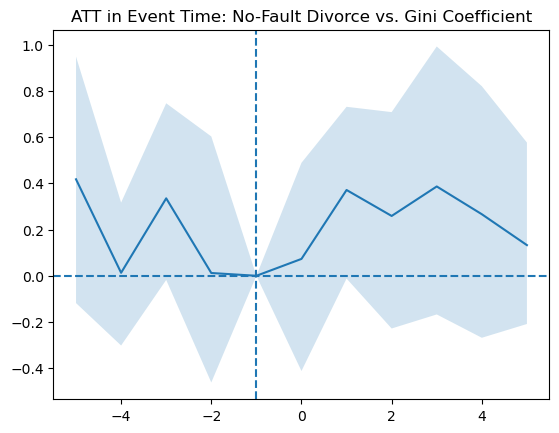

In [98]:
# plot ATT in Event Time

fig, ax = plt.subplots()

x_axis = event_time_att['event_time_binned']
y_axis = event_time_att['cell_mean']

plt.axvline(-1, linestyle='--')
plt.axhline(0, linestyle='--')

plt.plot(x_axis, y_axis)

#ci
x_axis_b = ci['e']
plt.fill_between(x_axis_b, ci['ci_low'], ci['ci_high'], alpha=0.2, label="95% CI")

plt.title("ATT in Event Time: No-Fault Divorce vs. Gini Coefficient")
plt.show()



# Event Study with Patsy Contrasts

In [106]:
# create new rel_year column and assign -1 value to NaN rows in rel_year (baseline)

df_es['rel_year_es'] = df_es['rel_year'].fillna(-1).clip(-5, 5)
df_es = df_es.rename(columns={'Treatment':'treatment'}) #rename treatment col to avoid clash with patsy 

In [107]:
# att with patsy formula

Y = "Gini_recon_hybrid"

# use rel_year_es instead of OnTreat
formula = f"{Y} ~ C(rel_year_es, Treatment(reference=-1)) + C(Country) + C(Year)"

results = smf.ols(formula=formula, data=df_es).fit(
    cov_type = 'cluster',
    cov_kwds = {"groups":df_es['Country']}
)

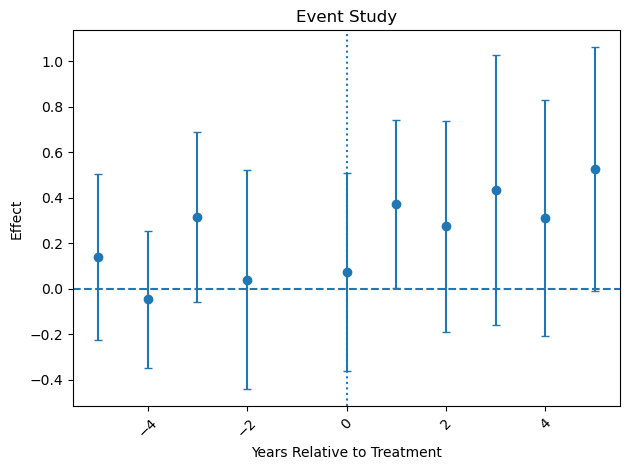

In [108]:
# event study plot

coefs = results.params.filter(like='rel_year_es')
ses = results.bse.filter(like='rel_year_es')

coefs_names = [int(float(s.split("T.")[1].rstrip(']'))) for s in coefs.index]

event_df = pd.DataFrame({
    'Relative Time': coefs_names,
    'Coefficient':coefs.values,
    'Standard Error':ses.values
})

event_df = event_df.sort_values(by='Relative Time', ascending=True)

event_df

# # plot the results

fig, ax = plt.subplots()
plt.axhline(0, linestyle='--')
plt.axvline(0, linestyle=':')

plt.errorbar(
    x = event_df['Relative Time'], y = event_df['Coefficient'], yerr=1.96*event_df['Standard Error'],
    fmt='o', capsize=3
)
plt.xlabel('Years Relative to Treatment')
plt.ylabel('Effect')
plt.title("Event Study")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Event Study with Manual Dummies

In [155]:
# repeat event study with manual dummies for validation and understanding

cats = [-1] + sorted(c for c in df_es['rel_year_es'].dropna().unique() if c != -1)

df_es['rel_year_es'] = pd.Categorical(df_es['rel_year_es'], categories=cats, ordered=True)

E = pd.get_dummies(df_es['rel_year_es'], drop_first=True, prefix='k')

e_names_term = " + ".join([f"Q('{c}')" for c in E.columns])

# fit model

results = smf.ols(
    f"Gini_recon_hybrid ~ 0 + {e_names_term} + C(Country) + C(Year)",
    data = df_es.assign(**E)
).fit(cov_type='cluster', cov_kwds={'groups':df_es['Country']})

In [156]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Gini_recon_hybrid   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 06 Oct 2025   Prob (F-statistic):                nan
Time:                        14:15:42   Log-Likelihood:                -13973.
No. Observations:                7808   AIC:                         2.834e+04
Df Residuals:                    7613   BIC:                         2.969e+04
Df Model:                         194                                         
Covariance Type:              cluster                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(Country)[Albania]                     69.0804      0.038   1829.928      0.000      69.006      69.154
C(Country)[Algeria]                     65.6944      0.038   1740.232      0.000      65.620      65.768
C(Country)[Argentina]                   54.3320      0.177    306.629      0.000      53.985      54.679
C(Country)[Armenia]                     68.4947      0.038   1814.411      0.000      68.421      68.569
C(Country)[Australia]                   66.1661      0.211    313.574      0.000      65.752      66.580
C(Country)[Austria]                     69.5186      0.207    336.175      0.000      69.113      69.924
C(Country)[Bangladesh]                  69.4877      0.038   1840.717      0.000      69.414      69.562
C(Country)[Belarus]                     72.2955      0.038   1915.095      0.000      72.222      72.369
C(Country)[Belgium]                     72.0578      0.180    401.358      0.000      71.706      72.410
C(Country)[Benin]                       59.6179      0.038   1579.266      0.000      59.544      59.692
C(Country)[Bolivia]                     49.7139      0.181    275.418      0.000      49.360      50.068
C(Country)[Bosnia and Herzegovina]      67.1855      0.204    329.168      0.000      66.785      67.586
C(Country)[Botswana]                    40.9959      0.214    191.630      0.000      40.577      41.415
C(Country)[Brazil]                      43.5743      0.178    244.297      0.000      43.225      43.924
C(Country)[Bulgaria]                    62.3713      0.179    348.994      0.000      62.021      62.722
C(Country)[Burkina Faso]                57.6510      0.038   1527.164      0.000      57.577      57.725
C(Country)[Burundi]                     63.0649      0.038   1670.578      0.000      62.991      63.139
C(Country)[Cameroon]                    56.4741      0.038   1495.988      0.000      56.400      56.548
C(Country)[Central African Republic]    46.5749      0.038   1233.760      0.000      46.501      46.649
C(Country)[Chad]                        60.5688      0.038   1604.456      0.000      60.495      60.643
C(Country)[Chile]                       49.3600      0.181    272.641      0.000      49.005      49.715
C(Country)[China]                       61.0289      0.038   1616.646      0.000      60.955      61.103
C(Country)[Colombia]                    45.9254      0.189    242.731      0.000      45.555      46.296
C(Country)[Comoros]                     49.4590      0.038   1310.160      0.000      49.385      49.533
C(Country)[Congo, Dem. Rep.]            57.0804      0.038   1512.050      0.000      57.006      57.154
C(Country)[Costa Rica]                  52.5413      0.038   1391.810      0.000      52.467      52.615
C(Country)[Cote d'Ivoire]             

In [161]:
# inspect results

coefs = results.params.filter(like='k_')
ses = results.bse.filter(like='k_')
p_vals = results.pvalues.filter(like='k_')
t_vals = results.tvalues.filter(like='k_')

In [172]:
# view results

results_df = (
    pd.DataFrame(pd.concat([coefs, ses, p_vals, t_vals], axis=1))
    .rename(columns={0:'coefficient', 1:'se', 2:'pval', 3:'tval'})
)

results_df

,coefficient,se,pval,tval
Q('k_-5.0'),0.140258,0.186171,0.451220,0.753383
Q('k_-4.0'),-0.045557,0.153823,0.767101,-0.296169
Q('k_-3.0'),0.315974,0.190651,0.097450,1.657342
Q('k_-2.0'),0.040194,0.245924,0.870172,0.163440
Q('k_0.0'),0.075033,0.222056,0.735438,0.337900
Q('k_1.0'),0.372397,0.189313,0.049172,1.967098
Q('k_2.0'),0.274010,0.237101,0.247816,1.155670
Q('k_3.0'),0.434234,0.302491,0.151137,1.435527
Q('k_4.0'),0.311615,0.265110,0.239828,1.175417
Q('k_5.0'),0.526659,0.272673,0.053425,1.931469
